In [1]:
'''
Model:
    3 Layers GAT + 2 Layer FC
    hidden channel = 32
    training 1500 epoch
    Device Node Features = 5
    Train in Log HPWL
    Train for HPWL > Threshold (10000)
    

'''

'\nModel:\n    3 Layers GAT + 2 Layer FC\n    hidden channel = 32\n    training 1500 epoch\n    symmetric net\n    seperate capacitors and resistors\n    Device Node Features = 5\n    Train in Log HPWL\n    \n\n'

In [2]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, BatchNorm, Linear, GATConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
!python --version
!nvcc --version
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


cuda:1
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Device Node Features' Shape: (4500, 5)
Device Node Features' Mean: [8.2884856e+07 9.5396346e+08 7.7310615e+03 5.4090312e+03 9.1711110e-01]
Device Node Features' Std: [2.9770163e+08 1.8716833e+09 7.4117515e+03 9.5033213e+03 1.2663405e+00]
Net Node Features' Shape: (4325, 6)
Net Node Features' Mean: [6.4924854e-01 1.0543352e-01 4.0369943e-01 3.4751446e+00 3.9471447e+01
 3.0973297e+04]
Net Node Features' Std: [9.3648350e-01 3.0710986e-01 4.9063596e-01 3.5836630e+00 3.1141081e+01
 4.0331391e+04]
DataSet size:
258
Total Device: 4500
NumMos: 2771
NumCap: 370
NumRes: 320
NumBlock: 1039
Num wire: 3869
L min:5.123964
L max:13.18503
Interval: 0.06893414974212647


/tmp/ipykernel_27244/2236915981.py:2: RuntimeWarning: divide by zero encountered in log
  wirelength = np.log(net_features_list[:,-1])


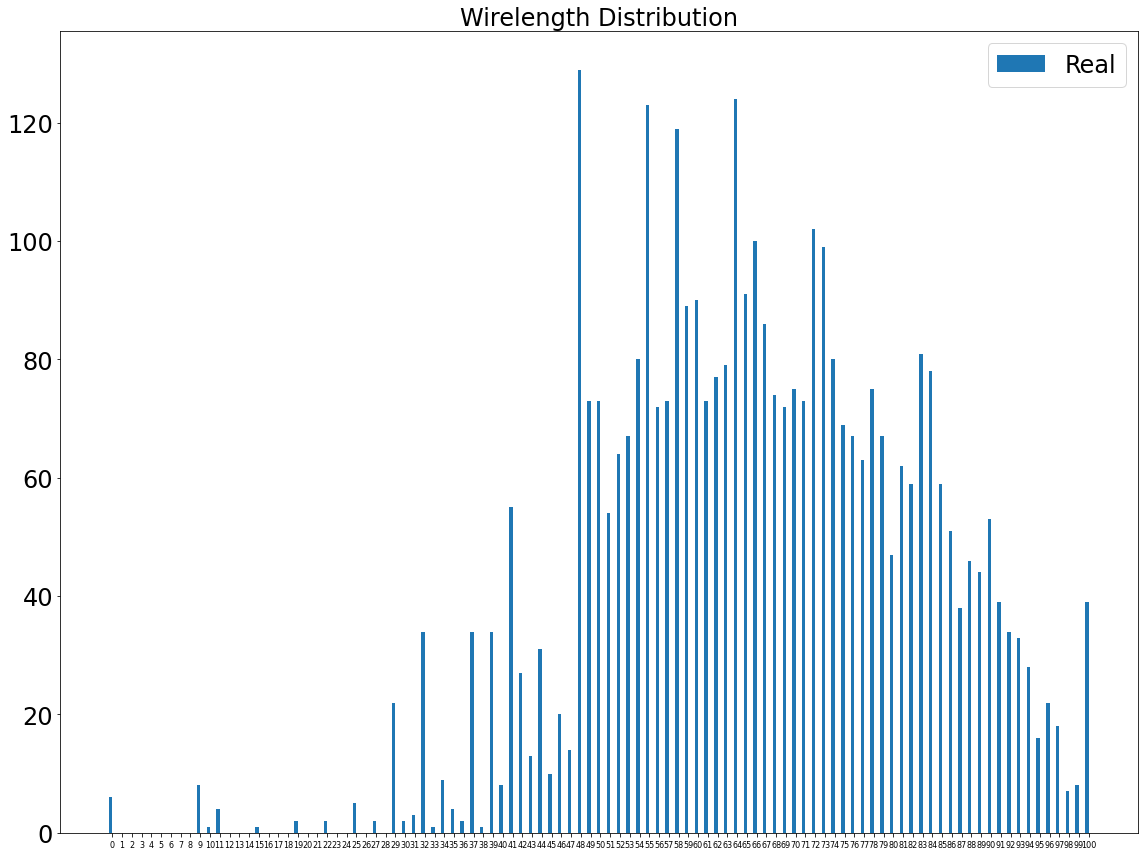

Num device: 4500
L min:1209600.0
L max:3048860000.0
Interval: 20889803.52


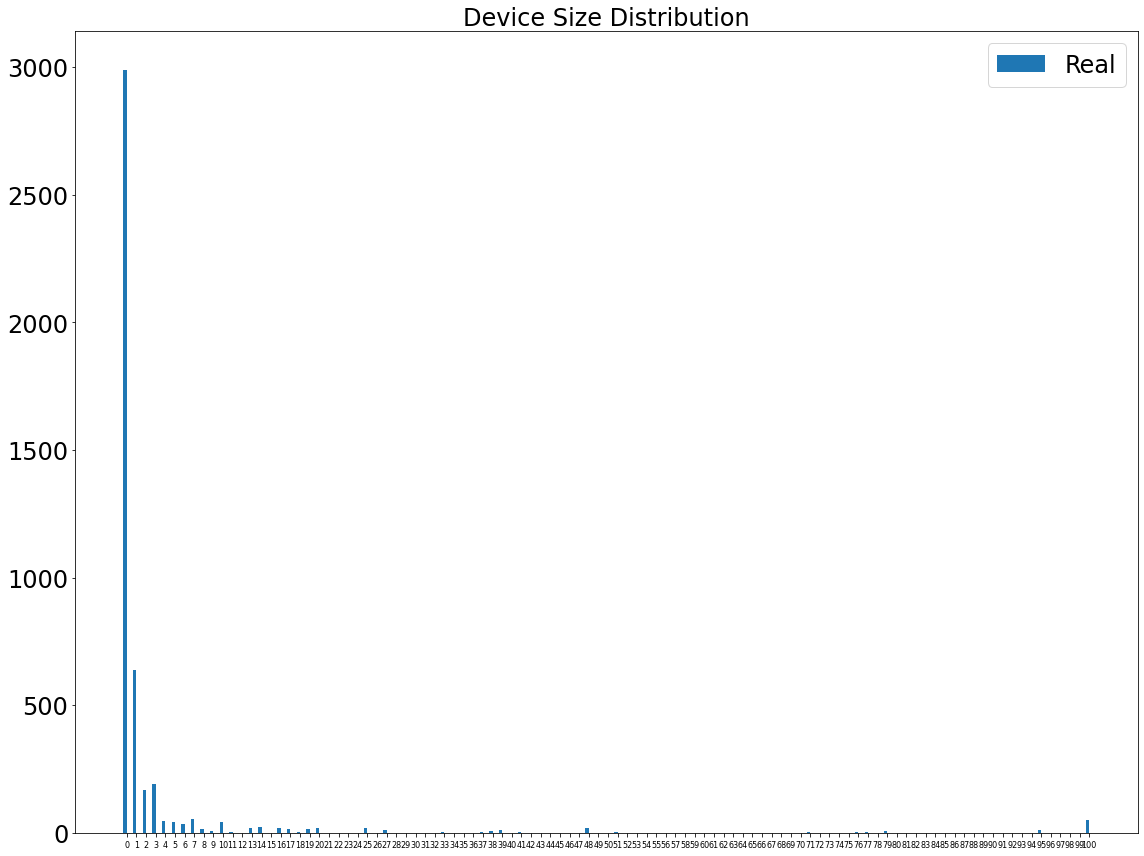

ALIGN(258)


In [4]:
%run ./Dataset_Generation_for_Log_HPWL.ipynb
#import import_ipynb
#import Dataset_Generation.ipynb
dataset = ALIGN(root='data_Log_Case')

In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset


train_dataset = dataset[0:233]
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = dataset[233:]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(train_dataset)

ALIGN(233)


In [6]:
for i, data in enumerate(train_loader):
    print(i)
    print(data)
    print(data.edge_index_dict[('device', 'gate2net', 'net')])
    print(data.edge_index_dict[('net', 'net2gate', 'device')])
    break

0
HeteroDataBatch(
  device={
    x=[48, 5],
    batch=[48],
    ptr=[5]
  },
  net={
    y=[44],
    train_mask=[44],
    smallnet_mask=[44],
    largenet_mask=[44],
    x=[44, 5],
    batch=[44],
    ptr=[5]
  },
  (device, gate2net, net)={ edge_index=[2, 30] },
  (net, net2gate, device)={ edge_index=[2, 30] },
  (device, source2net, net)={ edge_index=[2, 77] },
  (net, net2source, device)={ edge_index=[2, 77] },
  (device, cap2net, net)={ edge_index=[2, 12] },
  (net, net2cap, device)={ edge_index=[2, 12] },
  (device, res2net, net)={ edge_index=[2, 18] },
  (net, net2res, device)={ edge_index=[2, 18] },
  (net, net2net, net)={ edge_index=[2, 24] }
)
tensor([[ 0,  2,  1,  3,  7, 10, 11, 13, 12, 14, 44, 45, 33, 28, 32, 39, 24, 26,
         40, 46, 41, 25, 16, 27, 21, 22, 34, 19, 19, 45],
        [ 1,  1,  2,  2, 10, 11, 14, 14, 15, 15, 18, 19, 21, 21, 21, 21, 21, 22,
         23, 25, 25, 26, 29, 32, 35, 36, 37, 38, 41, 42]])
tensor([[ 1,  1,  2,  2, 10, 11, 14, 14, 15, 15, 18, 19, 21

In [7]:
class Hetero_Model (torch.nn.Module):
    
    def __init__(self, heads=2, hidden_channel=32):
        super().__init__()
        
        self.fc1_device = Linear(in_channels=5, out_channels=hidden_channel)
        self.fc1_net    = Linear(in_channels=5, out_channels=hidden_channel)
        
        self.hetero_conv1 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm1_device         = BatchNorm(hidden_channel*2)
        self.bnm1_net            = BatchNorm(hidden_channel*2)
        
        self.hetero_conv2 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm2_device         = BatchNorm(hidden_channel*2)
        self.bnm2_net            = BatchNorm(hidden_channel*2)
            
        self.hetero_conv3 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm3_device         = BatchNorm(hidden_channel*2)
        self.bnm3_net            = BatchNorm(hidden_channel*2)
        
        self.fc1  = Linear(hidden_channel*2*3, hidden_channel)
        self.bnm4 = BatchNorm(hidden_channel)
        self.fc2  = Linear(hidden_channel, 1)
        
    
    def forward(self, x_dict, edge_index_dict):
        
        x_dict['device'] = self.fc1_device(x_dict['device'])
        x_dict['net']    = self.fc1_net(x_dict['net'])
        

        x_dict           = self.hetero_conv1(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm1_device(x_dict['device'])
        x_dict['net']    = self.bnm1_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h1               = F.elu(x_dict['net'])
        
      
        x_dict           = self.hetero_conv2(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm2_device(x_dict['device'])
        x_dict['net']    = self.bnm2_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h2               = F.elu(x_dict['net'])
        
                
        x_dict           = self.hetero_conv3(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm3_device(x_dict['device'])
        x_dict['net']    = self.bnm3_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h3               = F.elu(x_dict['net'])
        
        x = torch.cat((h1, h2, h3), dim=1) 
        
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, 0.5, self.training)
        x = self.fc2(x)
        x = F.elu(x)
        
        return x

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)
model = Hetero_Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)
criterion = nn.MSELoss()


cuda:1


In [28]:
#model.to(device)
#model.load_state_dict(torch.load('./HAT_Log_HPWL_large_case.pth')['model_state_dict'])
#optimizer.load_state_dict(torch.load('./HAT_Log_HPWL_large_case.pth')['optimizer_state_dict'])

#print(device)


cuda:1


In [29]:
model.train()
Model_Path = './HAT_Log_HPWL_large_case.pth'

i = 0
for epoch in range(1500):
    model.train()
        
    for data in train_loader:
        
        optimizer.zero_grad()  
        data.to(device)
        out = model(data.x_dict, data.edge_index_dict).squeeze()
        if (out[data.largenet_mask_dict['net']].numel() == 0):
            continue
        
        loss = criterion(out[data.largenet_mask_dict['net']], data.y_dict['net'][data.largenet_mask_dict['net']])
        loss.backward()
        optimizer.step()
        
        #data.to('cpu')
        #torch.cuda.empty_cache()
    
    scheduler.step()
    if epoch%10 == 0:
        print(f'[{epoch + 1}] loss: {loss:.5f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)
    if epoch%100 == 0:
        print(f'[{epoch + 1}] lr: {optimizer.param_groups[0]["lr"]}')
    
    

[1] loss: 0.29368
[1] lr: 0.0001412376244999999
[11] loss: 0.09000
[21] loss: 0.70856
[31] loss: 0.86088
[41] loss: 0.20931
[51] loss: 0.17375
[61] loss: 0.49356
[71] loss: 0.07967
[81] loss: 0.23374
[91] loss: 0.19256
[101] loss: 0.30578
[101] lr: 9.886633714999992e-05
[111] loss: 0.42958
[121] loss: 0.90563
[131] loss: 0.18572
[141] loss: 0.29500
[151] loss: 0.46619
[161] loss: 0.18308
[171] loss: 0.27087
[181] loss: 1.01385
[191] loss: 0.09990
[201] loss: 0.52026
[201] lr: 6.920643600499994e-05
[211] loss: 0.25615
[221] loss: 0.21739
[231] loss: 0.24054
[241] loss: 0.17657
[251] loss: 0.36170
[261] loss: 0.24875
[271] loss: 0.11165
[281] loss: 0.20391
[291] loss: 0.40787
[301] loss: 0.04450
[301] lr: 4.844450520349996e-05
[311] loss: 0.68507
[321] loss: 0.46794
[331] loss: 0.28338
[341] loss: 0.10160
[351] loss: 0.95016
[361] loss: 0.13768
[371] loss: 0.29809
[381] loss: 0.11012
[391] loss: 0.16988
[401] loss: 0.51580
[401] lr: 3.391115364244997e-05
[411] loss: 0.06967
[421] loss: 0

In [30]:
Model_Path = './HAT_Log_HPWL_large_case.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)

In [48]:
model.load_state_dict(torch.load('./HAT_Log_HPWL_large_case.pth')['model_state_dict'])
optimizer.load_state_dict(torch.load('./HAT_Log_HPWL_large_case.pth')['optimizer_state_dict'])

In [55]:
model.eval()
test_acc_list = []
out_list = []
ans_list = []
model.to('cpu')

for data in test_loader:
    
    #print(data.x_dict)
    out = model(data.x_dict, data.edge_index_dict).squeeze()
    loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
    print(loss)
    
    out = torch.exp(out[data.train_mask_dict['net']]).detach().numpy()
    #print(out)
    
    ans = torch.exp(data.y_dict['net'][data.train_mask_dict['net']]).detach().numpy()
    #print(ans)
    
    mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans, out)), ans)), 100)
    mse = np.mean(np.absolute(np.subtract(ans, out)))
    print("MAPE: " + str(mape) + "%")
    print("MSE: " + str(mse))
    print()
    

    for i in range(out.shape[0]):
        if(ans[i] >=10000):
            out_list.append(out[i])
            ans_list.append(ans[i])
    
        
#print(out_list)
#print(ans_list)

print(len(out_list))
print(len(ans_list))

out_list = np.array(out_list)
ans_list = np.array(ans_list) 
overall_mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list)), 100)
overall_mse = np.mean(np.absolute(np.subtract(ans_list, out_list)))
print("Overall MAPE: " + str(overall_mape) + "%")
print("Overall MSE: " + str(overall_mse))

tensor(0.7092, grad_fn=<MseLossBackward0>)
MAPE: 122.79630899429321%
MSE: 12951.347

tensor(1.3807, grad_fn=<MseLossBackward0>)
MAPE: 421.8639850616455%
MSE: 19350.81

tensor(0.8121, grad_fn=<MseLossBackward0>)
MAPE: 122.30808734893799%
MSE: 21451.902

tensor(0.8374, grad_fn=<MseLossBackward0>)
MAPE: 137.68726587295532%
MSE: 14030.516

tensor(1.2081, grad_fn=<MseLossBackward0>)
MAPE: 195.7044243812561%
MSE: 15197.288

tensor(0.8356, grad_fn=<MseLossBackward0>)
MAPE: 144.68615055084229%
MSE: 9132.889

tensor(1.0046, grad_fn=<MseLossBackward0>)
MAPE: 174.2971897125244%
MSE: 12330.745

tensor(1.3380, grad_fn=<MseLossBackward0>)
MAPE: 278.15988063812256%
MSE: 10897.84

tensor(0.3567, grad_fn=<MseLossBackward0>)
MAPE: 71.16551399230957%
MSE: 6415.0376

tensor(1.2199, grad_fn=<MseLossBackward0>)
MAPE: 260.6096029281616%
MSE: 14255.744

tensor(0.6760, grad_fn=<MseLossBackward0>)
MAPE: 111.21985912322998%
MSE: 12840.128

tensor(0.4732, grad_fn=<MseLossBackward0>)
MAPE: 85.73142886161804%
MSE: 

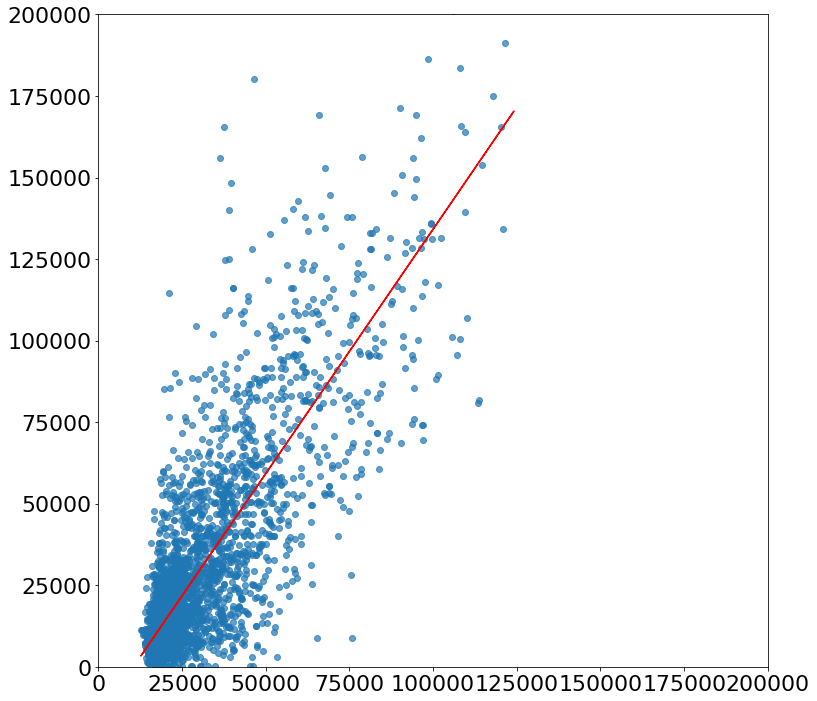

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (12, 12))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax.scatter(out_list, ans_list, alpha=0.7)
ax.set_xlim(0, 200000)
ax.set_ylim(0, 200000)

m, b = np.polyfit(out_list, ans_list, 1)
plt.plot(out_list, m*out_list + b, 'r')

plt.show()

In [44]:
N = 50

num_wire = len(out_list)
ans_sorted = np.sort(ans_list)
#out_sorted = np.sort(out_list) 
print("Num wire: " + str(num_wire))
    
L_min = ans_sorted[0]
L_max = ans_sorted[(num_wire-1) - int(0.05*num_wire)]
print("L min:" + str(L_min))
print("L max:" + str(L_max))
    
ans_label = np.zeros(num_wire)
out_label = np.zeros(num_wire)
interval = (L_max-L_min) / N
print("Interval: " + str(interval))
    
       
for i in range(N+1):
    interval_min = L_min + (i*interval)
    interval_max = L_min + ((i+1)*interval)
        
    if (i == N):
        ans_label = np.where((ans_list >= interval_min), i, ans_label)
        out_label = np.where((out_list >= interval_min), i, out_label)
    else:
        ans_label = np.where((ans_list >= interval_min) & (ans_list < interval_max), i, ans_label)
        out_label = np.where((out_list >= interval_min) & (out_list < interval_max), i, out_label)
            
#print(out_label)
#print(ans_label)
 
avg_value = np.zeros(N+1)
bin_num = np.zeros(N+1)
pred_avg_value = np.zeros(N+1)
pred_bin_num = np.zeros(N+1)
    
print("correlation: ")
    
for i in range(N+1):
    
    ans_mask = np.where(ans_label == i, True, False)
    bin_num[i] = len(ans_list[ans_mask])
    avg_value[i] = np.mean(ans_list[ans_mask])
        
    pred_mask = np.where(out_label == i, True, False)
    pred_bin_num[i] = len(out_list[pred_mask])
    pred_avg_value[i] = np.mean(out_list[pred_mask])

print(bin_num)
print(pred_bin_num)
    
#print(avg_value)
#print(pred_avg_value)
    
#print(np.corrcoef(avg_value, pred_avg_value))
      
    
print("MAPE:")
    
mape = np.multiply(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list), 100)
   
mape_list = []
for i in range(N+1):
    out_mask = np.where(out_label == i, True, False)
    mape_list.append(np.mean(mape[out_mask]))
        
#print(mape)
print(mape.mean())
print(mape_list)
    
    
print("====================================")
#break

Num wire: 2195
L min:10000.001
L max:109040.01
Interval: 1980.80015625
correlation: 
[183. 144. 189. 136. 109.  88.  74. 112.  80.  70.  54.  56.  41.  46.
  37.  50.  29.  25.  38.  24.  36.  45.  29.  33.  28.  25.  21.  19.
  17.  14.  14.  14.  15.  12.   7.  12.  21.  17.  14.  18.   8.  14.
   6.  16.   3.  12.   6.   8.   7.   9. 110.]
[  0.  11.  51. 174. 208. 231. 172. 146. 102. 105.  89.  71.  81.  71.
  78.  64.  67.  46.  36.  24.  32.  39.  20.  24.  20.  21.  23.  13.
  11.  14.  10.   5.   6.  12.  18.   4.   8.   7.   9.   7.   5.   8.
   9.  15.   4.   6.   1.   1.   3.   3.  10.]
MAPE:
40.033657
[nan, 21.625435, 23.511993, 30.04622, 34.532864, 38.616707, 37.335506, 48.724525, 40.484978, 50.41508, 45.840736, 38.17603, 50.270786, 51.678646, 51.253338, 51.17177, 42.018963, 59.564823, 53.16663, 32.639156, 47.323868, 32.61795, 47.85556, 38.141933, 31.343164, 33.080544, 31.220936, 24.27293, 42.45232, 31.266857, 28.637127, 37.554768, 26.78758, 22.384346, 32.30984, 25.944984,

/edahome/msedalab/deyuan/anaconda3/envs/GNN_PyG/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/edahome/msedalab/deyuan/anaconda3/envs/GNN_PyG/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


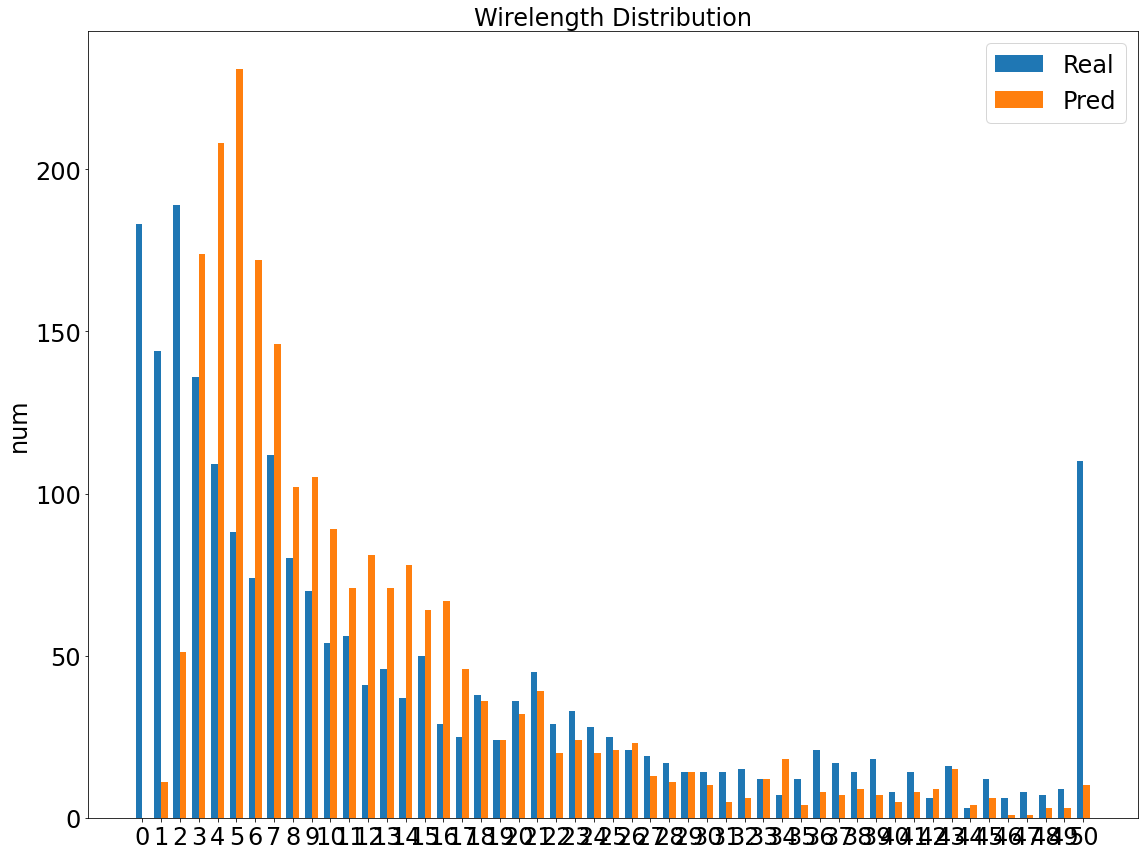

In [45]:
import matplotlib.pyplot as plt
labels = [i for i in range(N+1)]

x = np.arange(N+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_num, width, label='Real')
rects2 = ax.bar(x + width/2, pred_bin_num, width, label='Pred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('num', fontsize=24)
ax.set_title('Wirelength Distribution', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()


In [ ]:
labels = [i for i in range(20)]



x = np.arange(20)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mape_list, width, label='MAPE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%', fontsize=24)
ax.set_title('MAPE', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()